In [5]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss
from utils import DICOMDataset

In [6]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 10
image_size = 128
classes = ["nodule", "non-nodule"]
train_ratio = 0.8

np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

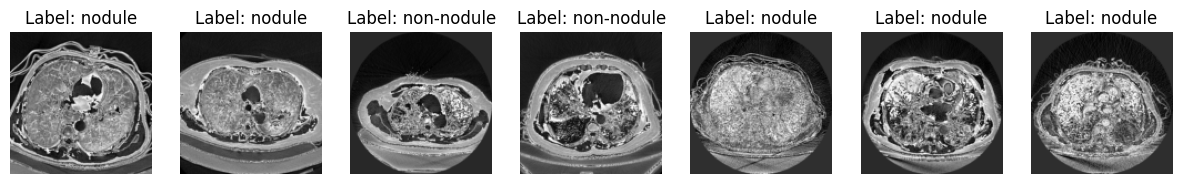

In [15]:
dataset = DICOMDataset(root_dir=BASE_DIR, num_images_per_class=1000, classes=["nodule", "non-nodule"], transform=transform)
dataset.visualize_images(num_images=7)

In [16]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

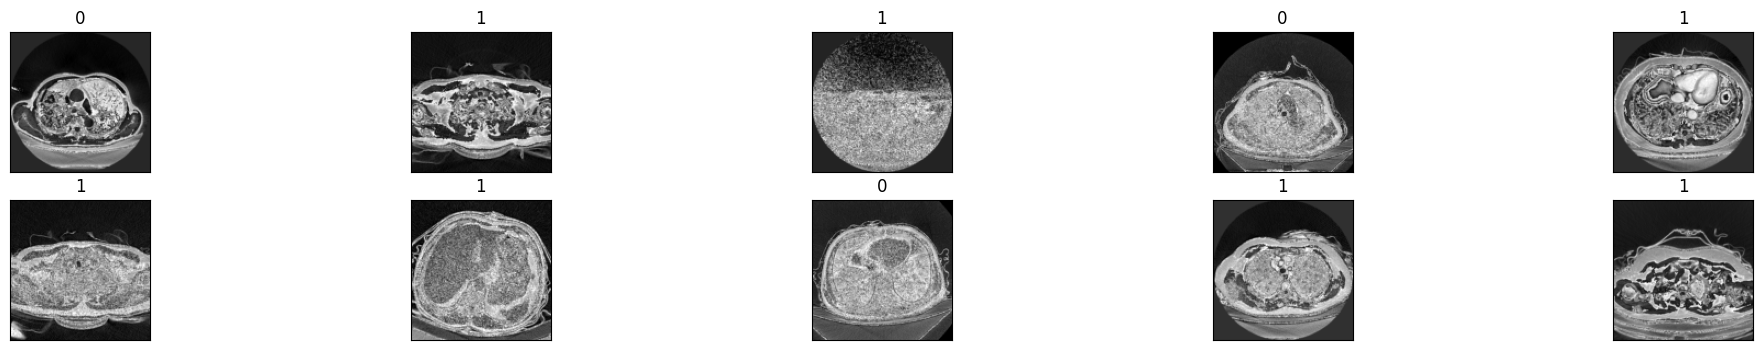

In [17]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [18]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [19]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [20]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

Epoch: 1 	Training Loss: 15.24307489
Epoch: 1 	Training Loss: 7.82703257
Epoch: 1 	Training Loss: 7.16639090
Epoch: 1 	Training Loss: 7.59539938
Epoch: 1 	Training Loss: 6.54062510
Epoch: 1 	Training Loss: 6.40569687
Epoch: 1 	Training Loss: 6.42715073
Epoch: 1 	Training Loss: 5.30212402
Epoch: 1 	Training Loss: 5.18191433
Epoch: 1 	Training Loss: 4.71726942
Epoch: 1 	Training Loss: 4.60253477
Epoch: 1 	Training Loss: 4.34737015
Epoch: 1 	Training Loss: 3.68610740
Epoch: 1 	Training Loss: 3.67246413
Epoch: 1 	Training Loss: 3.52803206
Epoch: 1 	Training Loss: 3.16832876
Epoch: 1 	Training Loss: 3.30049682
Epoch: 1 	Training Loss: 3.44367671
Epoch: 1 	Training Loss: 3.21508026
Epoch: 1 	Training Loss: 3.04393458
Epoch: 1 	Training Loss: 2.92520452
Epoch: 1 	Training Loss: 3.00454021
Epoch: 1 	Training Loss: 3.02761912
Epoch: 1 	Training Loss: 3.16804552
Epoch: 1 	Training Loss: 3.11324811
Epoch: 1 	Training Loss: 3.06607437
Epoch: 1 	Training Loss: 2.81031275
Epoch: 1 	Training Loss: 3.

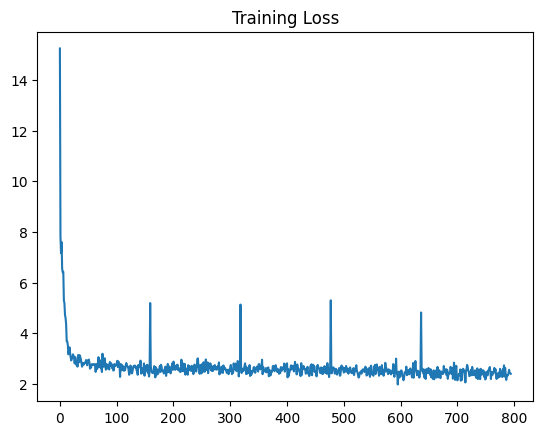

In [21]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [22]:
def display_images(images, reconstructions):
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, image_size, image_size)
    reconstructions = reconstructions.data.cpu().numpy()
    fig, axs = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))
    for images, row in zip([images, reconstructions], axs):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

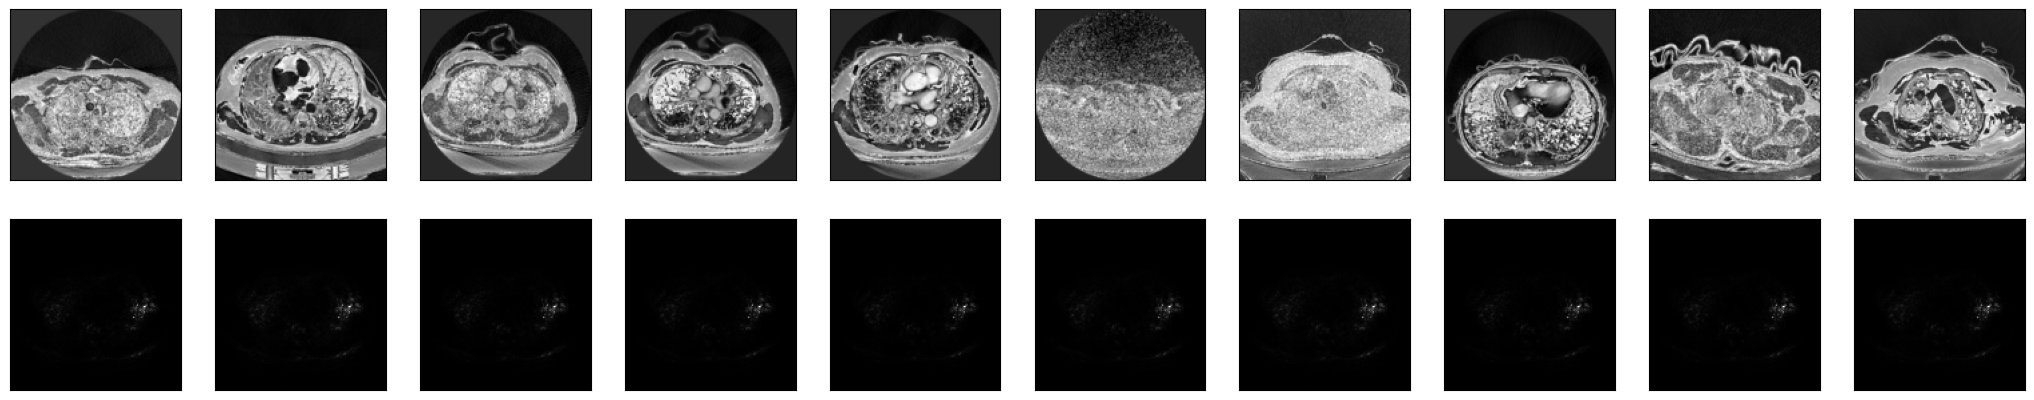

In [23]:
display_images(images, reconstructions)